# Lab 4 — Bidding Predictions for Construction
**Course:** Machine Learning

**Authors:**
- Kimly John Vergara
- Daniel Mark Wiegand

**Instructor:**
Anfernee Joan Bajar Ng

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import  StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


## 1. Load Dataset

Load all dataset splits from the provided CSV files:
- `raw_train.csv` — training data with pay-item rows and `total_bid` labels
- `raw_test.csv` — test data with the same features (no `total_bid`)
- `sample_submission.csv` — expected submission format


In [2]:
df         = pd.read_csv("bidding-predictions-for-construction/raw_train.csv")
df_test    = pd.read_csv("bidding-predictions-for-construction/raw_test.csv")
sample_sub = pd.read_csv("bidding-predictions-for-construction/sample_submission.csv")

print("Train shape:      ", df.shape)
print("Test shape:       ", df_test.shape)
print("Sample sub shape: ", sample_sub.shape)


Train shape:       (832056, 15)
Test shape:        (120305, 13)
Sample sub shape:  (1447, 2)


## 2. Exploratory Data Analysis (EDA)

Perform an initial exploration of the dataset to understand its structure, distribution, and quality before any modelling work.

### 2.1 Missing Values & Data Overview

Check for null values across all columns and inspect basic data types and non-null counts. This helps identify columns that may require imputation or removal.


In [3]:
df.isna().sum()

quantity                    0
amount                      0
job_category_description    0
bid_date                    0
total_bid                   0
num_pay_items               0
pay_item_description        0
unit_english_id             2
category_id                 0
category_description        0
job_id                      0
contractor_id               0
primary_location            0
pay_item_id                 0
row_id                      0
dtype: int64

### 2.2 Missing Values Imputation

`unit_english_id` has a small number of missing values. We impute them using the **training set mode** for both train and test to prevent any leakage from test data.


In [4]:
# Compute mode from training set only — reuse for test imputation
train_unit_mode = df["unit_english_id"].mode()[0]

df["unit_english_id"]      = df["unit_english_id"].fillna(train_unit_mode)
df_test["unit_english_id"] = df_test["unit_english_id"].fillna(train_unit_mode)

print("Remaining nulls (train):", df.isna().sum().sum())
print("Remaining nulls (test): ", df_test.isna().sum().sum())


Remaining nulls (train): 0
Remaining nulls (test):  0


### 2.3 Feature Distributions

Histograms for numerical features and value counts for key categorical columns.
Note: `amount` is only available in the training set and is excluded from modelling features.


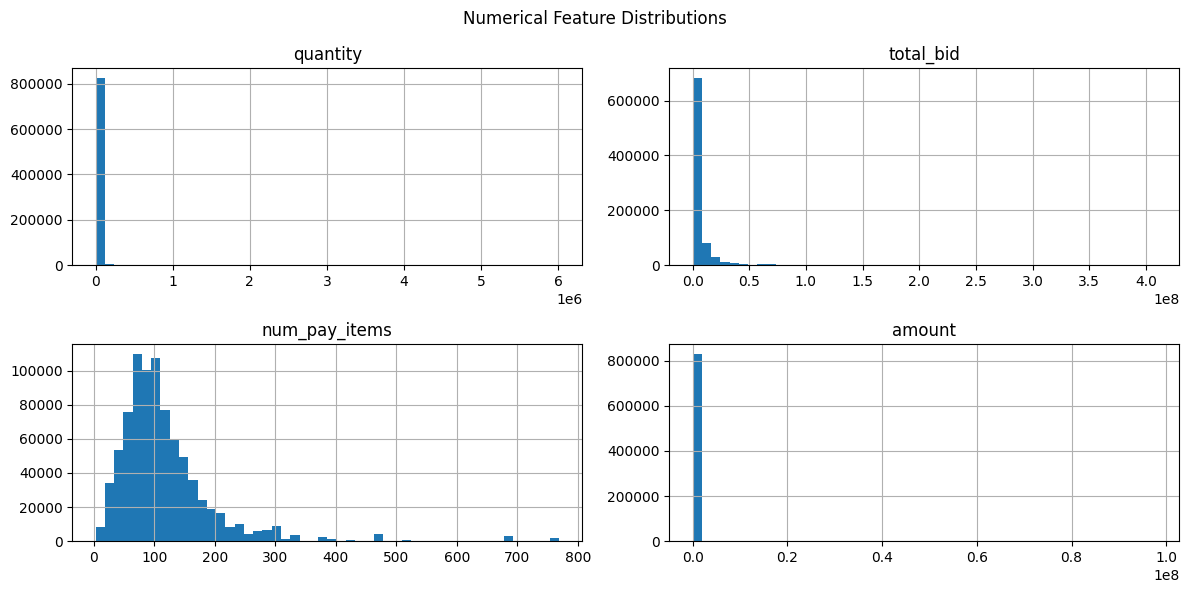

In [5]:
# Histograms for numerical features (train-only columns included for exploration)
numerical_cols = ["quantity", "total_bid", "num_pay_items", "amount"]
df[numerical_cols].hist(bins=50, figsize=(12, 6))
plt.suptitle("Numerical Feature Distributions")
plt.tight_layout()
plt.show()



Our data tells that most of the numerical data is left skewed. It is probably because most bids are at lower price. it makes sense because they compete for lower bids.

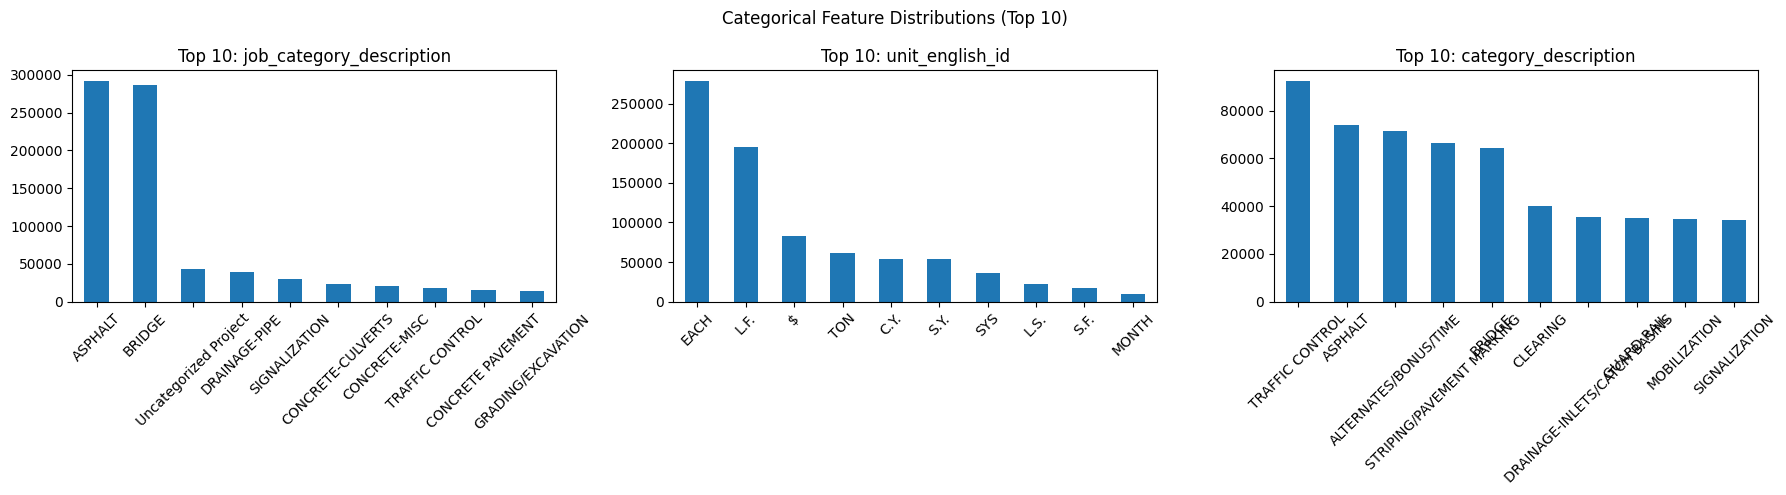

In [6]:
cat_cols_eda = ["job_category_description", "unit_english_id", "category_description"]

fig, axes = plt.subplots(1, len(cat_cols_eda), figsize=(18, 5))
for ax, col in zip(axes, cat_cols_eda):
    counts = df[col].value_counts().head(10)
    counts.plot(kind="bar", ax=ax)
    ax.set_title(f"Top 10: {col}")
    ax.set_xlabel("")
    ax.tick_params(axis="x", rotation=45)

plt.suptitle("Categorical Feature Distributions (Top 10)")
plt.tight_layout()
plt.show()


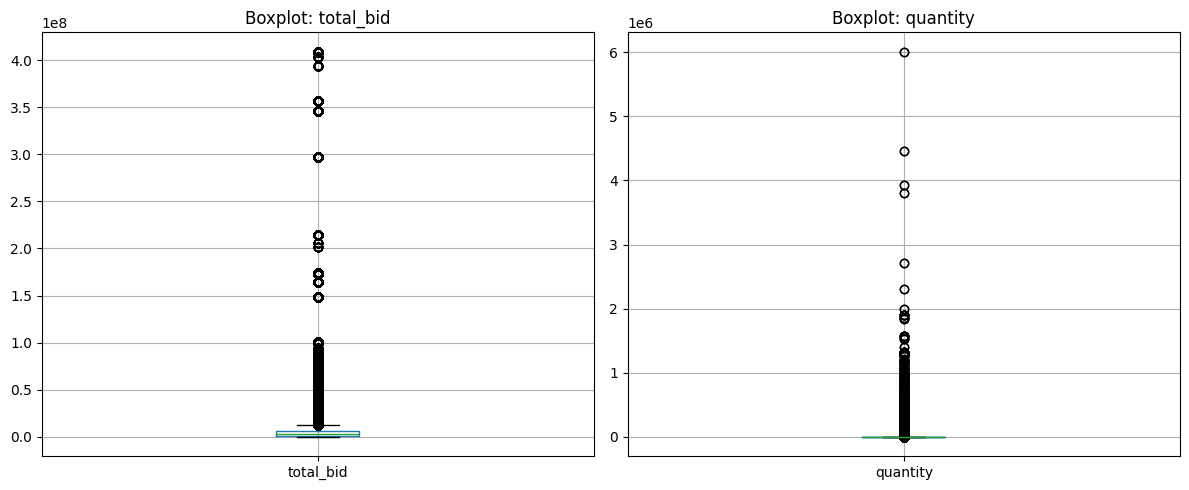

total_bid: 89968 outliers (10.8%)
quantity: 139707 outliers (16.8%)


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

df.boxplot(column="total_bid", ax=axes[0])
axes[0].set_title("Boxplot: total_bid")

df.boxplot(column="quantity", ax=axes[1])
axes[1].set_title("Boxplot: quantity")

plt.tight_layout()
plt.show()

# IQR-based outlier counts
for col in ["total_bid", "quantity"]:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)]
    print(f"{col}: {len(outliers)} outliers ({len(outliers)/len(df)*100:.1f}%)")



### 2.5 Outlier Removal

Remove rows where `total_bid` or `quantity` fall outside the IQR fence (Q1 − 1.5×IQR, Q3 + 1.5×IQR). The filter is computed on the **training set only** and applied only to `df`; test data is left unchanged.


In [8]:
before = len(df)

for col in ["total_bid", "quantity"]:
    Q1  = df[col].quantile(0.25)
    Q3  = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df  = df[(df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)]

df = df.reset_index(drop=True)
print(f"Rows removed: {before - len(df):,}  ({(before - len(df)) / before * 100:.1f}%)")
print(f"Remaining rows: {len(df):,}")


Rows removed: 213,552  (25.7%)
Remaining rows: 618,504


after multiple trial and error. removing the outliers helped our models achiever a better rmse score.

### 2.6 Patterns & Correlations

Investigate relationships between features and the target variable:
- Correlation matrix / heatmap for numerical features
- `total_bid` trends over time (`bid_date`)
- Differences in bidding behaviour across `job_category_description`


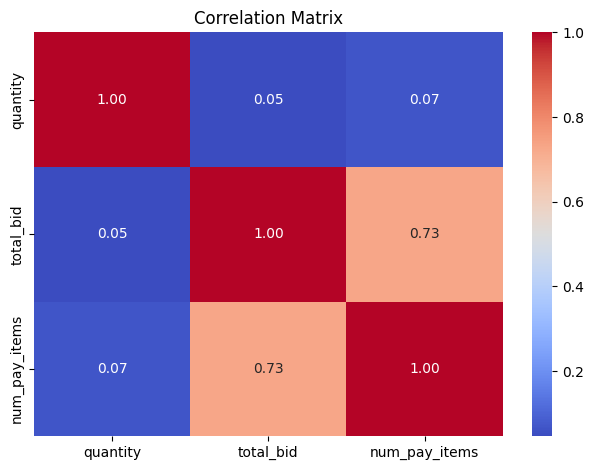

count    6.185040e+05
mean     3.063118e+06
std      2.743453e+06
min      1.286500e+04
25%      1.056151e+06
50%      2.141328e+06
75%      4.189375e+06
max      1.299339e+07
Name: total_bid, dtype: float64

In [9]:
# Correlation heatmap (features available in both train and test)
numerical_cols = ["quantity", "total_bid", "num_pay_items"]
corr = df[numerical_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()




df["total_bid"].describe()


total_bid shows a strong correlation with num_pay_items 

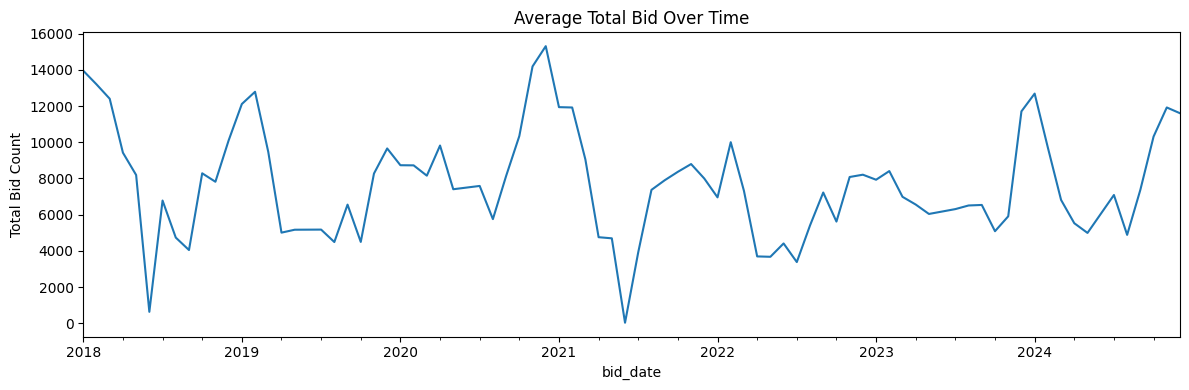

In [10]:
# Total bid over time
df["bid_date"] = pd.to_datetime(df["bid_date"])
df.groupby(df["bid_date"].dt.to_period("M"))["total_bid"].count().plot(
    figsize=(12, 4), title="Average Total Bid Over Time"
)
plt.ylabel("Total Bid Count")
plt.tight_layout()
plt.show()



we could tell that there are consistent total bids across the years. with an exception during 2021 - 2022 and 2018 - 2019, this could be the cause of pandemic (start and its end)

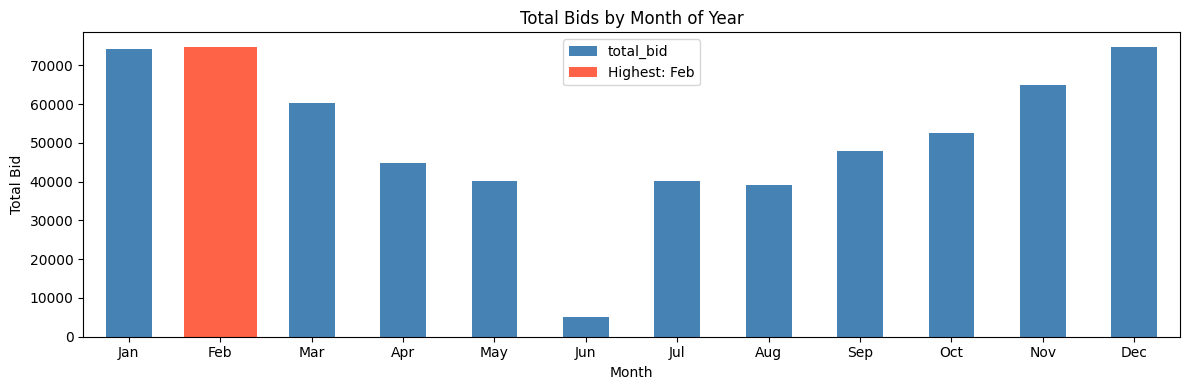

In [11]:

# Average total bid by month of year — which month has the most?
df["bid_date"] = pd.to_datetime(df["bid_date"])
df["bid_month"] = df["bid_date"].dt.month

monthly_avg = df.groupby("bid_month")["total_bid"].count()
monthly_avg.index = df.groupby("bid_month")["bid_date"].first().dt.strftime("%b")

ax = monthly_avg.plot(kind="bar", figsize=(12, 4), title="Total Bids by Month of Year", color="steelblue")
ax.bar(monthly_avg.values.argmax(), monthly_avg.max(), color="tomato", label=f"Highest: {monthly_avg.idxmax()}")
plt.ylabel("Total Bid")
plt.xlabel("Month")
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.show()


we could tell most bids happen during feb abd least during june. It could be because of certain seasons or weather conditions or simply a coincidence?

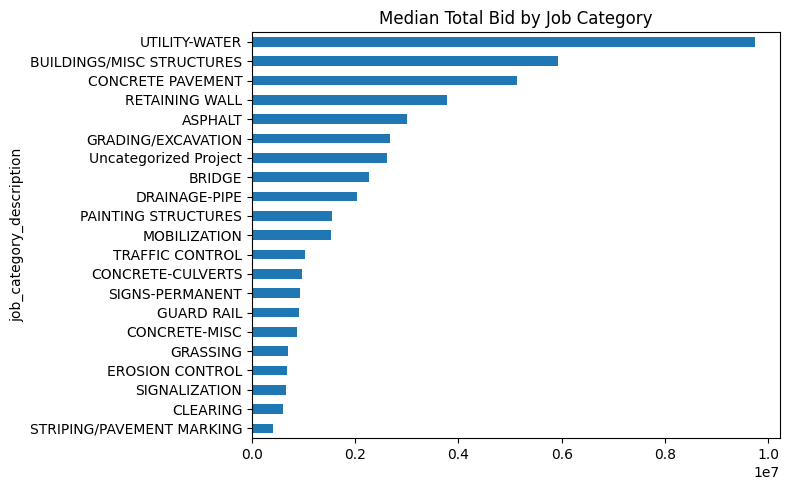

In [12]:
# Total bid by job category
df.groupby("job_category_description")["total_bid"].median().sort_values().plot(
    kind="barh", figsize=(8, 5), title="Median Total Bid by Job Category"
)
plt.tight_layout()
plt.show()

We utilized median to avoid extreme outliers. Data suggests that Utility-Water projects dominate the median bid values as the most bid.

## 3. Feature Engineering

Transform and enrich the raw features to improve model performance:
- Extract temporal features from `bid_date` (year, month)
- Encode categorical variables using `OneHotEncoder`
- Scale numerical features such as (`quantity`, `num_pay_items`) **after** the train/val split to prevent leakage


### 3.1 Temporal Features

Extract year and month from `bid_date`. 


In [13]:
def add_temporal_features(frame: pd.DataFrame) -> pd.DataFrame:
    frame = frame.copy()
    frame["bid_date"] = pd.to_datetime(frame["bid_date"])
    frame["bid_year"]  = frame["bid_date"].dt.year
    frame["bid_month"] = frame["bid_date"].dt.month
    return frame

df = add_temporal_features(df)
df_test = add_temporal_features(df_test)


### 3.2 Categorical Encoding

Encode categorical columns using `pd.get_dummies`. The encoder is **fit on training data only** — dummy columns are created from `df`, then `df_test` is aligned to the same columns (filling any missing dummies with `0`).

In [14]:
cat_cols = [
    "job_category_description", "unit_english_id",
    "category_description", "primary_location"
]

# One-hot encode on train, then align test to the same columns (fill missing with 0)
df      = pd.get_dummies(df,      columns=cat_cols, dtype=int)
df_test = pd.get_dummies(df_test, columns=cat_cols, dtype=int)
df_test = df_test.reindex(columns=df.columns.drop("total_bid"), fill_value=0)

dummy_cols = [c for c in df.columns if any(c.startswith(cat + "_") for cat in cat_cols)]
print(f"Generated {len(dummy_cols)} dummy columns")
df[dummy_cols].head()

Generated 168 dummy columns


,job_category_description_ASPHALT,job_category_description_BRIDGE,job_category_description_BUILDINGS/MISC STRUCTURES,job_category_description_CLEARING,job_category_description_CONCRETE PAVEMENT,job_category_description_CONCRETE-CULVERTS,job_category_description_CONCRETE-MISC,job_category_description_DRAINAGE-PIPE,job_category_description_EROSION CONTROL,job_category_description_GRADING/EXCAVATION,...,primary_location_LOC_000084,primary_location_LOC_000085,primary_location_LOC_000086,primary_location_LOC_000087,primary_location_LOC_000088,primary_location_LOC_000089,primary_location_LOC_000090,primary_location_LOC_000091,primary_location_LOC_000092,primary_location_LOC_000093
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4. Train / Validation Split & Scaling

Split the processed training data. `StandardScaler` is **fit on `X_train` only** and then applied to `X_val` and `X_test`, preventing any validation or test statistics from leaking into the scaling step. Dummy columns from `pd.get_dummies` are included as-is (already binary) alongside the scaled numerical features.

In [15]:
num_cols   = ["quantity", "num_pay_items"]
base_cols  = num_cols + ["bid_year", "bid_month"]
feature_cols = base_cols + dummy_cols
target_col = "total_bid" 

X = df[feature_cols].copy()
y = df[target_col]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit scaler on X_train only
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols]   = scaler.transform(X_val[num_cols])

X_test = df_test[feature_cols].copy()
X_test[num_cols]  = scaler.transform(X_test[num_cols])

print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")

Train size: 494803, Validation size: 123701, Test size: 120305


## 5. Modeling


### 5.2 Model Selection and Hyperparameter Tuning 

Use `RandomizedSearchCV` with `scoring="neg_mean_absolute_error"` to tune `HistGradientBoostingRegressor`. `n_iter=30` gives broader coverage of the search space compared to the default 10.


In [ ]:
pipeline = Pipeline([("model", HistGradientBoostingRegressor())])

param_distributions = [
    {
        "model":                    [HistGradientBoostingRegressor(random_state=42)],
        "model__max_iter":          [100, 200, 300],
        "model__learning_rate":     [0.01, 0.05, 0.1, 0.2],
        "model__max_depth":         [3, 5, 7, None],
        "model__l2_regularization": [0.0, 0.1, 1.0],
        "model__max_leaf_nodes":    [15, 31, 63],
        "model__min_samples_leaf":  [20, 50, 100],
    },
    {
        "model":                    [RandomForestRegressor(random_state=42, n_jobs=-1)],
        "model__n_estimators":      [100, 200],
        "model__max_depth":         [3, 5, 7, None],
        "model__min_samples_leaf":  [10, 20, 50],
    },
    {
        "model":        [Ridge()],
        "model__alpha": [0.1, 1.0, 10.0],
    },

    {
        "model":                [XGBRegressor(random_state=42, n_jobs=-1, tree_method="hist")],
        "model__n_estimators":  [200, 400],
        "model__learning_rate": [0.01, 0.05, 0.1],
        "model__max_depth":     [4, 6, 8],
        "model__subsample":     [0.7, 0.85, 1.0],
        "model__colsample_bytree": [0.7, 0.85, 1.0],
        "model__reg_lambda":    [0.0, 1.0, 5.0],
    },
    {
        "model":                [LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1)],
        "model__n_estimators":  [200, 400],
        "model__learning_rate": [0.01, 0.05, 0.1],
        "model__num_leaves":    [31, 63, 127],
        "model__subsample":     [0.7, 0.85, 1.0],
        "model__colsample_bytree": [0.7, 0.85, 1.0],
        "model__reg_lambda":    [0.0, 1.0, 5.0],
    },
    {
        "model":                    [ExtraTreesRegressor(random_state=42, n_jobs=-1)],
        "model__n_estimators":      [100, 200],
        "model__max_depth":         [5, 10, None],
        "model__min_samples_leaf":  [5, 10, 20],
    },
]

hgb_search = RandomizedSearchCV(
    pipeline, param_distributions=[param_distributions[0]],
    n_iter=5, cv=3, scoring="neg_mean_absolute_error",
    n_jobs=-1, random_state=42
)

rf_search = RandomizedSearchCV(
    pipeline, param_distributions=[param_distributions[1]],
    n_iter=5, cv=3, scoring="neg_mean_absolute_error",
    n_jobs=-1, random_state=42
)

ridge_search = RandomizedSearchCV(
    pipeline, param_distributions=[param_distributions[2]],
    n_iter=5, cv=3, scoring="neg_mean_absolute_error",
    n_jobs=-1, random_state=42
)

xgb_search = RandomizedSearchCV(
    pipeline, param_distributions=[param_distributions[3]],
    n_iter=5, cv=3, scoring="neg_mean_absolute_error",
    n_jobs=-1, random_state=42
)

lgbm_search = RandomizedSearchCV(
    pipeline, param_distributions=[param_distributions[4]],
    n_iter=5, cv=3, scoring="neg_mean_absolute_error",
    n_jobs=-1, random_state=42
)

et_search = RandomizedSearchCV(
    pipeline, param_distributions=[param_distributions[5]],
    n_iter=5, cv=3, scoring="neg_mean_absolute_error",
    n_jobs=-1, random_state=42
)

searches = {
    "HGB":   hgb_search,
    "RF":    rf_search,
    "Ridge": ridge_search,
    "XGB":   xgb_search,
    "LGBM":  lgbm_search,
    "ET":    et_search,
}

best_score = float("-inf")
best_model = None
best_params = None
best_name = None

for name, search in searches.items():
    print(f"\n--- Fitting {name} ---")
    search.fit(X_train, y_train)
    print(f"  Best CV MAE: {-search.best_score_:,.2f}")
    if search.best_score_ > best_score:
        best_score = search.best_score_
        best_model = search.best_estimator_
        best_params = search.best_params_
        best_name = name

print(f"\nBest model:  {best_name}")
print(f"Best params: {best_params}")
print(f"Best CV MAE: {-best_score:,.2f}")



--- Fitting HGB ---
Fitting 3 folds for each of 5 candidates, totalling 15 fits


the best model is that of the random forest. it could be that the dataset works better with tree based models.

## 6. Evaluation

Assess the best model on the validation set using the relevant metrics (MAE, RMSE). Visualise residuals and feature importances to confirm the model is learning meaningful signals and not overfitting.

Pipeline(steps=[('model',
                 HistGradientBoostingRegressor(l2_regularization=1.0,
                                               learning_rate=0.2, max_iter=300,
                                               max_leaf_nodes=63,
                                               min_samples_leaf=50,
                                               random_state=42))])
Validation MAE:  250,839.20
Validation RMSE: 390,483.65


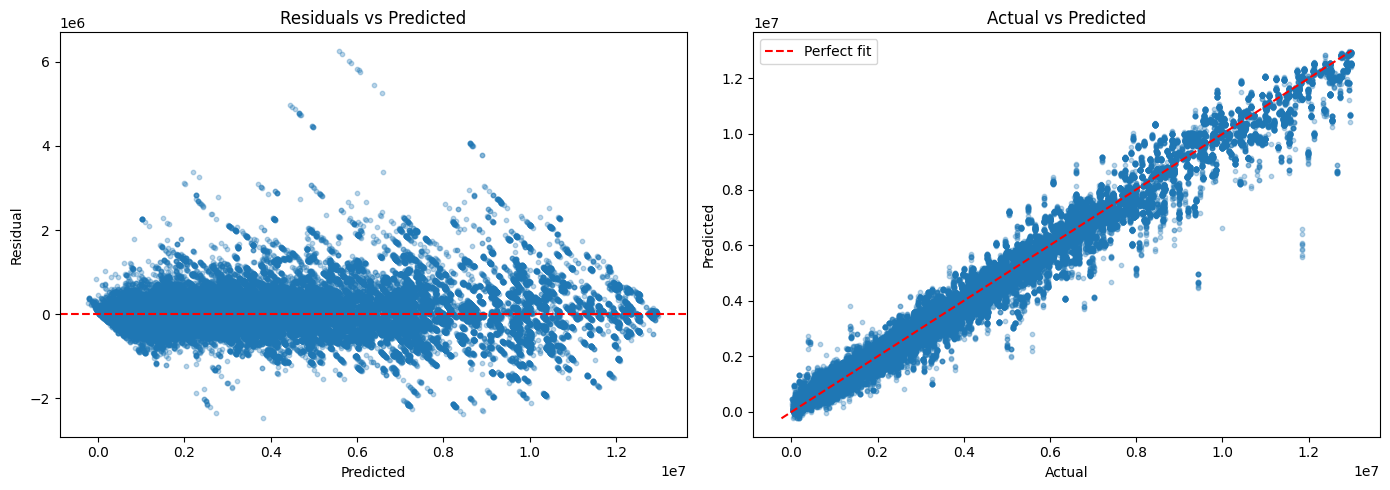

In [ ]:
print(best_model)
val_preds = best_model.predict(X_val)
mae  = mean_absolute_error(y_val, val_preds)
rmse = root_mean_squared_error(y_val, val_preds)
print(f"Validation MAE:  {mae:,.2f}")
print(f"Validation RMSE: {rmse:,.2f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residuals plot
residuals = y_val - val_preds
axes[0].scatter(val_preds, residuals, alpha=0.3, s=10)
axes[0].axhline(0, color="red", linestyle="--")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Residual")
axes[0].set_title("Residuals vs Predicted")

# Actual vs Predicted plot
axes[1].scatter(y_val, val_preds, alpha=0.3, s=10)
min_val = min(y_val.min(), val_preds.min())
max_val = max(y_val.max(), val_preds.max())
axes[1].plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", label="Perfect fit")
axes[1].set_xlabel("Actual")
axes[1].set_ylabel("Predicted")
axes[1].set_title("Actual vs Predicted")
axes[1].legend()

plt.tight_layout()
plt.show()


we can see that the data fits the line, it seems that the model performs better on smaller data.

## 7. Prediction on Test Set

`X_test` was preprocessed using the same fitted encoders and scaler in Section 4. We predict `total_bid` for each pay-item row, then aggregate to one prediction per `row_id` by taking the **mean** across pay items belonging to the same job.


In [ ]:
test_preds = best_model.predict(X_test)
df_test["predicted_total_bid"] = test_preds

# Aggregate to one prediction per row_id — mean across pay items
test_submission = (
    df_test.groupby("row_id")["predicted_total_bid"]
    .mean()
    .reset_index()
)
print(f"Generated {len(test_submission)} job-level predictions")


Generated 1447 job-level predictions


## 8. Submission

Format the predictions according to `sample_submission.csv` and save the result to a CSV file ready for upload.

In [ ]:
submission = test_submission.rename(columns={"predicted_total_bid": "total_bid"})

# Align to the exact row order defined by sample_submission.csv
submission = sample_sub[["row_id"]].merge(submission, on="row_id", how="left")

submission.to_csv("submission.csv", index=False)
print("Saved submission.csv")
submission.head()


Saved submission.csv


,row_id,total_bid
0,JOB_000008__CON_000103,8.722269e+05
1,JOB_000030__CON_000061,1.043548e+06
2,JOB_000030__CON_000217,1.043548e+06
3,JOB_000045__CON_000037,2.093564e+06
4,JOB_000045__CON_000122,2.093564e+06
